In [1]:
%tensorflow_version 1.x
import gym
import random
import numpy as np
import tensorflow as tf
import time
from gym.envs.registration import register
from IPython.display import clear_output
from collections import deque
print("Using OpenAI Gym:", gym.__version__)
print("Using Tensorflow:", tf.__version__)

TensorFlow 1.x selected.
Using OpenAI Gym: 0.17.3
Using Tensorflow: 1.15.2


In [2]:
try:
    register(
        id='FrozenLakeNoSlip-v0',
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name' : '4x4', 'is_slippery':False},
        max_episode_steps=100,
        reward_threshold=0.78, # optimum = .8196
    )
except:
    pass
env_name = "FrozenLakeNoSlip-v0"
env = gym.make(env_name)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
type(env.action_space)

Observation space: Discrete(16)
Action space: Discrete(4)


gym.spaces.discrete.Discrete

In [3]:
class Agent():
    def __init__(self, env):
        self.is_discrete = \
            type(env.action_space) == gym.spaces.discrete.Discrete
        
        if self.is_discrete:
            self.action_size = env.action_space.n
            print("Action size:", self.action_size)
        else:
            self.action_low = env.action_space.low
            self.action_high = env.action_space.high
            self.action_shape = env.action_space.shape
            print("Action range:", self.action_low, self.action_high)
        
    def get_action(self, state):
        if self.is_discrete:
            action = random.choice(range(self.action_size))
        else:
            action = np.random.uniform(self.action_low,
                                       self.action_high,
                                       self.action_shape)
        return action

In [4]:
class QNAgent(Agent):
    def __init__(self, env, discount_rate=0.97, learning_rate=0.001):
        super().__init__(env)
        self.state_size = env.observation_space.n
        print("State size:", self.state_size)
        
        self.eps = 1.0
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.build_model()
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.replay_buffer = deque(maxlen=1000)
        
    def build_model(self):
        tf.reset_default_graph()
        self.state_in = tf.placeholder(tf.int32, shape=[None])
        self.action_in = tf.placeholder(tf.int32, shape=[None])
        self.target_in = tf.placeholder(tf.float32, shape=[None])
        
        self.state = tf.one_hot(self.state_in, depth=self.state_size)
        self.action = tf.one_hot(self.action_in, depth=self.action_size)
        
        self.q_state = tf.layers.dense(self.state, units=self.action_size, name="q_table")
        self.q_action = tf.reduce_sum(tf.multiply(self.q_state, self.action), axis=1)
        
        self.loss = tf.reduce_sum(tf.square(self.target_in - self.q_action))
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
    def get_action(self, state):
        q_state = self.sess.run(self.q_state, feed_dict={self.state_in: [state]})
        action_greedy = np.argmax(q_state)
        action_random = super().get_action(state)
        return action_random if random.random() < self.eps else action_greedy
    
    def train(self, experience, batch_size=50):
        self.replay_buffer.append(experience)
        samples = random.choices(self.replay_buffer, k=batch_size)
        state, action, next_state, reward, done = (list(col) for col in zip(experience, *samples))
#         state, action, next_state, reward, done = ([exp] for exp in experience)
        
        q_next = self.sess.run(self.q_state, feed_dict={self.state_in: next_state})
        q_next[done] = np.zeros([self.action_size])
        q_target = reward + self.discount_rate * np.max(q_next, axis=1)
        
        feed = {self.state_in: state, self.action_in: action, self.target_in: q_target}
        self.sess.run(self.optimizer, feed_dict=feed)
        
        if experience[4]:
            self.eps = self.eps * 0.99
            
    def __del__(self):
        self.sess.close()
        
agent = QNAgent(env)

Action size: 4
State size: 16
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [5]:
l=[]
for i in range(5):
  total_reward = 0
  print(i)
  for ep in range(100):
      state = env.reset()
      done = False
      while not done:
          action = agent.get_action(state)
          next_state, reward, done, info = env.step(action)
          agent.train((state,action,next_state,reward,done))
          state = next_state
          total_reward += reward
          l.append(total_reward)
          
          print("s:", state, "a:", action)
          print("Episode: {}, Total reward: {}, eps: {}".format(ep,total_reward,agent.eps))
          env.render()
          with tf.variable_scope("q_table", reuse=True):
              weights = agent.sess.run(tf.get_variable("kernel"))
              print(weights)
          time.sleep(0.05)
          clear_output(wait=True)
  
      

s: 15 a: 2
Episode: 99, Total reward: 98.0, eps: 0.006570483042414605
  (Right)
SFFF
FHFH
FFFH
HFFG
[[ 0.3366211   0.31485835  0.25230858  0.24137235]
 [-0.11016124 -0.4314073   0.36805156  0.11724569]
 [ 0.09766787  0.36921757  0.34196067  0.12310754]
 [ 0.37883773 -0.4283132   0.06360824  0.22348051]
 [ 0.35603625  0.34157455 -0.40389755  0.24087249]
 [-0.10324317  0.12816262  0.30309832 -0.4648284 ]
 [-0.39968625  0.39721867 -0.05240698  0.00844093]
 [ 0.3507325   0.23888326  0.20202601  0.3138736 ]
 [ 0.3824812  -0.5438573   0.42055643  0.2672618 ]
 [ 0.38267112  0.39688852  0.44873184 -0.44477937]
 [ 0.4099745   0.42608017 -0.47315657  0.313502  ]
 [ 0.22057396  0.49150062  0.27417707 -0.21476248]
 [-0.3211618   0.43405694 -0.09610856  0.25486124]
 [-0.50251895  0.38124925  0.4778935   0.15789662]
 [ 0.4381474   0.4263153   0.50790775  0.34833002]
 [ 0.4521079   0.3785181  -0.17925435 -0.37297347]]


In [7]:
x= [i for i in range(len(l))]

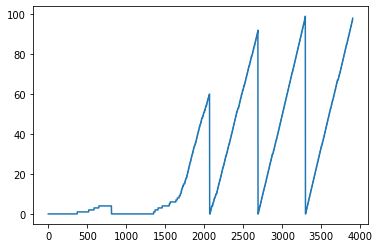

In [8]:
import matplotlib.pyplot as plt
plt.plot(x,l)

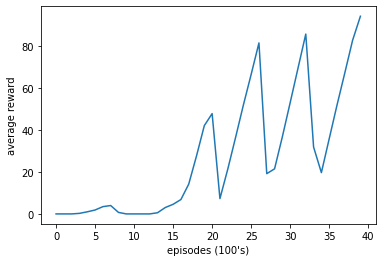

In [9]:
def get_average(values):
    
    return sum(values)/len(values)

avg_reward=[]
for i in range(0,len(l),99):
    avg_reward.append(get_average(l[i:i+100]))

plt.plot(avg_reward)
plt.ylabel('average reward')
plt.xlabel('episodes (100\'s)')
plt.show()
